In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

import shap 

np.random.seed(0)

/Users/racheltay/miniconda3/envs/cs5228_proj/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def drop_cols_for_regression(df):
    drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'total_num_units',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        'built_year',
        # to remove temporarily
        'planning_area',
        'subzone'
    ]
    """
        'gep_pri_sch_within_1km',
        'gep_pri_sch_within_1km_2km',
        'gep_pri_sch_outside_2km',
        'pri_sch_within_500m',
        'pri_sch_outside_500m',
        'line_cc',
        'line_ce',
        'line_cg',
        'line_dt',
        'line_ew',
        'line_ne',
        'line_ns',
        'line_te',
        'furnishing_partial',
        'furnishing_unfurnished',
        'furnishing_unspecified',
    ]
    """
    return df.drop(columns=drop_columns)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df = preprocess(df)
adfs = read_aux_csv('../data')
df = join_aux(df, adfs)
df = drop_cols_for_regression(df)


In [5]:
categorical_features = ["subzone", "planning_area", "region"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer.fit(df[['region']])
df[categorical_transformer.categories_[0]] = categorical_transformer.transform(df[['region']]).toarray()
df = df.drop(columns=['region'])

In [6]:
# rf don't need to scale
# numeric_transformer = StandardScaler()
# X_train = numeric_transformer.fit_transform(X_train)

In [7]:
df_train, df_valid = train_test_split(df, test_size=0.30)
df_train.head()

,num_beds,num_baths,size_sqft,lat,lng,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,...,cc_type_IHL,nearest_mall_distance_in_km,area_size,population,density,c,e,n,ne,w
6278,4.0,2.0,1281,1.382226,103.838766,892500.0,0,1,0,1,...,0,1.396052,0.8461,24150,28542.725446,0.0,0.0,0.0,1.0,0.0
14599,3.0,2.0,1173,1.302770,103.869435,3305400.0,1,0,0,1,...,1,0.382112,2.0506,11110,5417.926461,1.0,0.0,0.0,0.0,0.0
9158,3.0,2.0,1270,1.373940,103.858667,661500.0,0,1,0,1,...,0,1.209104,0.9557,28070,29371.141572,0.0,0.0,0.0,1.0,0.0
6377,2.0,1.0,560,1.329416,103.914886,839000.0,1,0,1,0,...,0,1.674648,2.3873,37460,15691.366816,0.0,1.0,0.0,0.0,0.0
15764,6.0,6.0,6211,1.367030,103.889966,5258400.0,1,0,0,1,...,0,0.680151,0.4417,4720,10685.985963,0.0,0.0,0.0,1.0,0.0


In [8]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_valid = df_valid.drop('price', axis=1)
y_valid = df_valid['price']

In [9]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

In [10]:
param_grid = {'max_depth': [5, 10, 15, 20, 25, 30]}
rf_model = RandomForestRegressor(random_state=0)

search = GridSearchCV(rf_model, param_grid, cv=10)
search.fit(X_train, y_train)
search.best_estimator_

RandomForestRegressor(max_depth=25, random_state=0)

In [11]:
pred_valid = search.best_estimator_.predict(X_valid)
print(rmse(y_valid, pred_valid))

703117.7288806814


In [12]:
df_test = preprocess(pd.read_csv('../data/test.csv'), is_target=True, num_beds=df_train['num_beds'].median(), num_baths=df_train['num_baths'].median())
adfs = read_aux_csv('../data')
df_test = join_aux(df_test, adfs)
df_test = drop_cols_for_regression(df_test)
df_test[categorical_transformer.categories_[0]] = categorical_transformer.transform(df_test[['region']]).toarray()
X_test = df_test.drop(columns=['region'])
X_test = X_test[X_train.columns]
X_test = X_test.fillna(-1)

y_pred = search.best_estimator_.predict(X_test)

X_test['Predicted'] = y_pred
submission = X_test[['Predicted']]
submission.to_csv('submission_rachel_1.csv', index=True, index_label='id', header=True, columns=['Predicted'])

which features are most important during model training? 

In [13]:
important_features_dict = {}
for idx, col in enumerate(X_train.columns):
    important_features_dict[col] = search.best_estimator_.feature_importances_[idx]

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:5]}')

5 most important features: ['size_sqft', 'lat', 'property_type_private', 'c', 'area_size']


how do each feature contribute to the model output? 

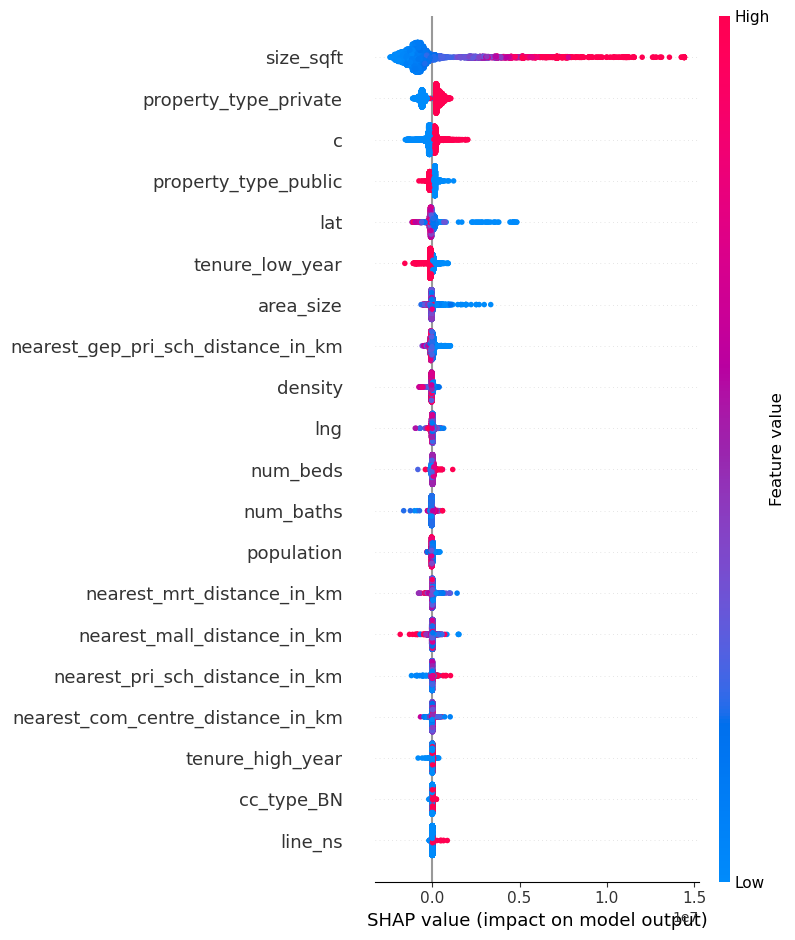

In [14]:
explainer = shap.TreeExplainer(search.best_estimator_)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)